<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 50px"><b>But de ce Notebook</b></h2>
<p style="font-family: Arial, sans-serif; font-size: 20px; color: white;">
Dans ce notebook, nous allons donner une définition novice de la sinistralité, et nous allons implémenter un GLM pour voir l'évolution temporelle de la sinistralité, ainsi que l'évolution régionale de cette dernière.
</p>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Définition de la sinistralité</b></h2>

<p style="font-family: Arial, sans-serif; font-size: 20px; color:white;">
En nous inspirant de la bibliographie 2, nous allons nous intéressé au reste à charge comme mesure de sinistralité car cela nous donne, dans la plupart des postes de soins, sur le prix maximale que doit payer les assurances aux assurés.
Et par reste à charge nous insinuons le ticket modérateur d'une prestation de santé + les éventuels dépassement d'honoraires.</p>



<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Dictionnaires nécessaires</b></h2>

In [330]:
region_mapping = {
    5: "Régions et Départements d'outre-mer",
    11: "Ile-de-France",
    24: "Centre-Val-de-Loire",
    27: "Bourgogne-Franche-Comté",
    28: "Normandie",
    32: "Grand Est et Hauts-de-France",
    44: "Grand Est et Hauts-de-France",
    52: "Pays de la Loire",
    53: "Bretagne",
    75: "Auvergne-Rhône-Alpes et Occitanie et Nouvelle-Aquitaine",
    76: "Auvergne-Rhône-Alpes et Occitanie et Nouvelle-Aquitaine",
    84: "Auvergne-Rhône-Alpes et Occitanie et Nouvelle-Aquitaine",
    93: "Provence-Alpes-Côte d'Azur et Corse"
}

demographie_mapping = {"Occitanie": "Auvergne-Rhône-Alpes et Occitanie et Nouvelle-Aquitaine",
                       "Nouvelle-Aquitaine": "Auvergne-Rhône-Alpes et Occitanie et Nouvelle-Aquitaine",
                       "Grand Est": "Grand Est et Hauts-de-France",
                       "Hauts-de-France": "Grand Est et Hauts-de-France",
                       "Auvergne-Rhône-Alpes": "Auvergne-Rhône-Alpes et Occitanie et Nouvelle-Aquitaine",
                       }

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Importation des librairies nécessaires</b></h2>

In [331]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, norm, gamma, skewnorm
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.simplefilter('ignore', category=UserWarning)


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Chargement des données et leurs visualisations</b></h2>

In [332]:
df = pd.read_csv("../../page 3/RAC_nouveau_2.csv")

Aperçu des données

In [333]:
df.head()

,SOI_ANN,SOI_MOI,BEN_SEX_COD,AGE_BEN_SNDS,BEN_RES_REG,RAC,FLT_PAI_MNT,FLT_REM_MNT
0,1.0,1.0,1.0,50.0,28.0,29169.19,41559.79,12390.60
1,1.0,1.0,2.0,60.0,27.0,5914.47,7829.40,1914.93
2,1.0,1.0,1.0,60.0,44.0,82594.40,147726.68,65132.28
3,1.0,1.0,2.0,60.0,53.0,10325.63,16926.19,6600.56
4,1.0,1.0,2.0,70.0,24.0,3796.22,6345.66,2549.44


Changement de types et extraction des mois et de l'année

In [334]:
df = df.astype({
    'AGE_BEN_SNDS': 'int32',
    'BEN_SEX_COD': 'int32',
    'BEN_RES_REG': 'int32',
    'SOI_ANN': 'int32',
    'SOI_MOI': 'int32'
})
df.head()

,SOI_ANN,SOI_MOI,BEN_SEX_COD,AGE_BEN_SNDS,BEN_RES_REG,RAC,FLT_PAI_MNT,FLT_REM_MNT
0,1,1,1,50,28,29169.19,41559.79,12390.60
1,1,1,2,60,27,5914.47,7829.40,1914.93
2,1,1,1,60,44,82594.40,147726.68,65132.28
3,1,1,2,60,53,10325.63,16926.19,6600.56
4,1,1,2,70,24,3796.22,6345.66,2549.44


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Filtrage des données</b></h2>

On enlève les valeurs inconnues pour le sexe et l'âge et on ne garde que les données agrégés mensuellement

In [335]:

df.rename(columns = {'SOI_ANN':'annee', 'SOI_MOI':'mois','AGE_BEN_SNDS': 'age', 'BEN_RES_REG': 'region', 'BEN_SEX_COD': 'sexe', 'FLT_PAI_MNT': 'PAI', 'FLT_REM_MNT': 'REM'}, inplace = True)

df['region'] = df['region'].map(region_mapping)

df_grouped = df.drop(columns = ['PAI', 'REM', 'age', 'mois', 'sexe']).groupby(by = ['annee',  'region']).sum()

df_grouped.reset_index(inplace=True)

df_grouped = df_grouped[df_grouped['annee'] >= 2019]

df_grouped


,annee,region,RAC
111,2019,Auvergne-Rhône-Alpes et Occitanie et Nouvelle-...,9.580379e+09
112,2019,Bourgogne-Franche-Comté,1.238660e+09
113,2019,Bretagne,1.367300e+09
114,2019,Centre-Val-de-Loire,1.105182e+09
115,2019,Grand Est et Hauts-de-France,5.320276e+09
116,2019,Ile-de-France,6.247058e+09
117,2019,Normandie,1.388909e+09
118,2019,Pays de la Loire,1.586728e+09
119,2019,Provence-Alpes-Côte d'Azur et Corse,2.881505e+09
120,2019,Régions et Départements d'outre-mer,6.736140e+08


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Création d'un champ population</b></h2>

Importation des données démographiques 

In [336]:
years = np.append(np.array([2018]), df_grouped['annee'].unique())
year_population_dataframes = {}
for year in years:
    print(f"Dataframe crée pour l'année {year}")
    df_year = pd.read_csv(f"../../CSV demographie/population par région fin {year}.csv", sep=';', decimal = ' ', encoding= "latin")
    df_year = pd.melt(df_year, value_vars=['Hommes','Femmes'], value_name="population", var_name="sexe", id_vars="Région")
    df_year['annee'] = year
    df_year.rename(columns={'Région': 'region'}, inplace=True)
    df_year['region'] = df_year['region'].apply(lambda x : demographie_mapping[x] if x in demographie_mapping else x)
    df_year.drop(columns= ['sexe'], inplace=True)
    df_year['population'] = df_year['population'].str.replace(' ','')
    df_year['population'] = df_year['population'].astype(float)
    df_year = df_year.groupby(by = ['annee', 'region']).sum().reset_index()
    year_population_dataframes[year] = df_year


Dataframe crée pour l'année 2018
Dataframe crée pour l'année 2019
Dataframe crée pour l'année 2020
Dataframe crée pour l'année 2021
Dataframe crée pour l'année 2022
Dataframe crée pour l'année 2023
Dataframe crée pour l'année 2024


Interpolation mensuelle des données démographiques par région

In [339]:
def interpolate_population(data_1, data_2):
    # Copier les données des deux années pour éviter de modifier les originaux
    df_year_1 = data_1.copy()
    df_year_2 = data_2.copy()
    
    # Calculer la différence annuelle de population et la diviser par 12 pour obtenir les incréments mensuels
    difference_yearly_pop = ((df_year_2['population'] - df_year_1['population']) / 12).to_list()
    
    # Créer une liste des populations interpolées mensuellement
    df_year_2['monthly_population'] = [
        [df_year_1['population'].iloc[i] + j * difference_yearly_pop[i] for j in range(1, 13)]
        for i in range(len(df_year_1))
    ]
    df_year_2['mois'] = list(range(1, 13) for _ in range(len(df_year_1))) 
    
    # Transformer les listes en lignes individuelles
    df_year_2 = df_year_2.explode(['monthly_population', 'mois']).reset_index(drop=True)

    # Supprimer la colonne 'population' car elle n'est plus nécessaire
    df_year_2.drop(columns=['population'], inplace=True)

    # Trier les données par année et mois
    df_year_2.sort_values(by=['annee', 'mois'])

    return df_year_2

# Interpoler les données pour toutes les années disponibles
def interpolate_all_data(data):
    all_data = {}
    for year in sorted(data.keys())[:-1]: 
        # Récupérer les données de deux années consécutives
        data_1 = year_population_dataframes[year]
        data_2 = year_population_dataframes[year + 1]
        # Interpoler les données entre ces deux années
        all_data[year + 1] = interpolate_population(data_1, data_2)
    
    # Combiner toutes les données interpolées en un seul DataFrame
    return pd.concat(all_data.values())

# Appliquer l'interpolation à toutes les données démographiques
all_data = pd.concat(year_population_dataframes.values())
all_data


,annee,region,population
0,2018,Auvergne-Rhône-Alpes et Occitanie et Nouvelle-...,19986410.0
1,2018,Bourgogne-Franche-Comté,2805580.0
2,2018,Bretagne,3354854.0
3,2018,Centre-Val-de-Loire,2573180.0
4,2018,Grand Est et Hauts-de-France,11561166.0
...,...,...,...
5,2024,Ile-de-France,12450849.0
6,2024,Normandie,3341312.0
7,2024,Pays de la Loire,3936719.0
8,2024,Provence-Alpes-Côte d'Azur et Corse,5601749.0


Fusion des données de l'Open Damir avec les données démographiques

In [340]:
# on va merge les dataframes

copied_df = df_grouped.copy()

# Merge les dataframes sur 'annee', 'age', et 'sexe'.
final_df = copied_df.merge(all_data, how = 'right', on= ['annee', 'region'], suffixes=('', '_new'))

final_df['population'] = final_df['population'].astype(float) * 0.9

final_df['RAC'] = final_df['RAC'].astype(float)


final_df['RAC_par_personne'] = final_df['RAC'] / final_df['population'] 

final_df.shape


(70, 5)

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Visualisation du reste à charge par région</b></h2>

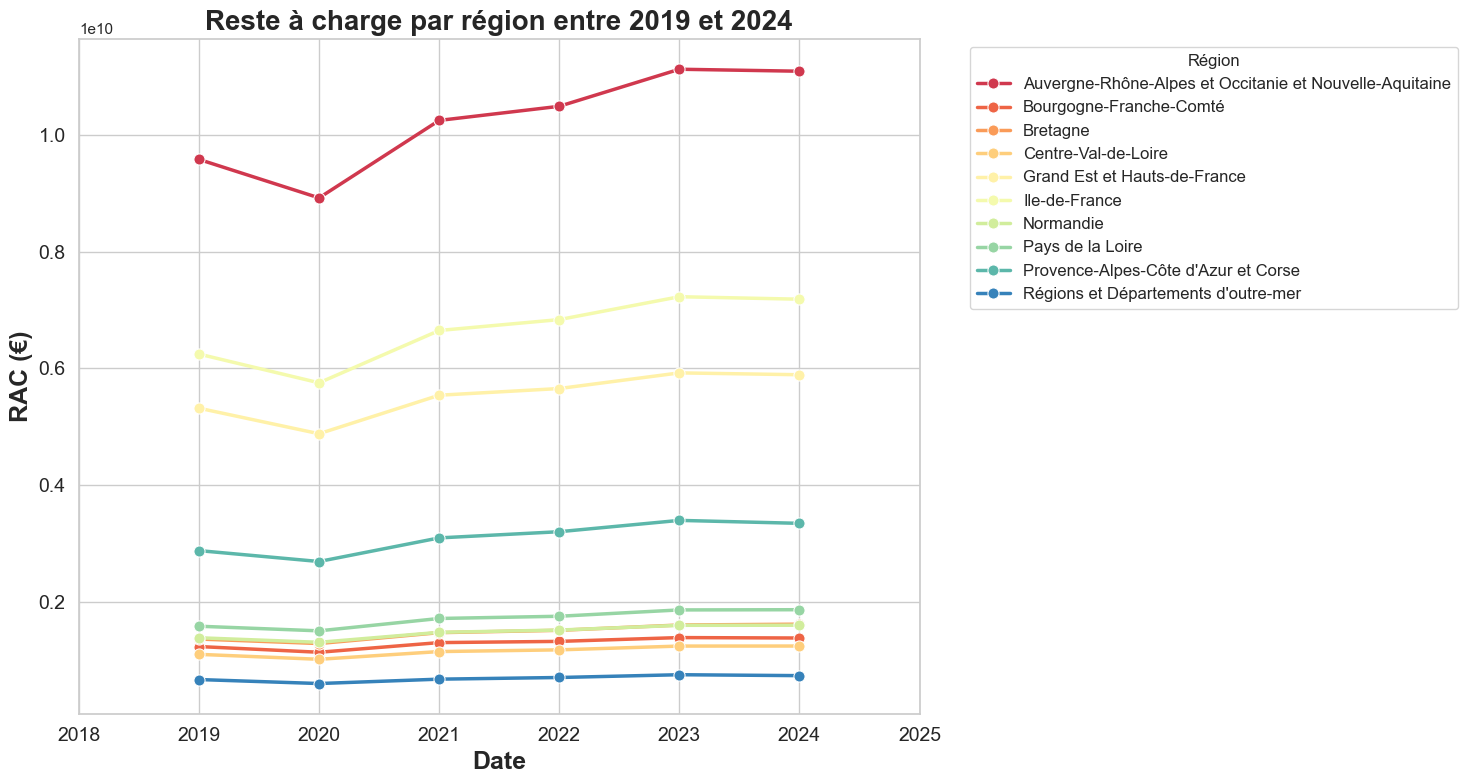

In [341]:
# Définir le style de la visualisation
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

# Tracer une courbe pour visualiser le reste à charge (RAC) par région entre 2019 et 2024
sns.lineplot(
    x="annee",  # Axe des x : années
    y="RAC",  # Axe des y : reste à charge (RAC)
    data=final_df,  # Données utilisées pour la visualisation
    hue="region",  # Différencier les courbes par région
    marker='o',  # Ajouter des marqueurs pour chaque point
    markersize=8,  # Taille des marqueurs
    linewidth=2.5,  # Épaisseur des lignes
    errorbar=None,  # Pas de barres d'erreur
    estimator=np.sum,  # Estimation basée sur la somme des valeurs
    palette="Spectral"  # Palette de couleurs pour différencier les régions
)

# Ajouter un titre avec une taille de police plus grande
plt.title("Reste à charge par région entre 2019 et 2024", fontsize=20, fontweight='bold')

# Ajouter des étiquettes aux axes avec une taille de police plus grande
plt.xlabel("Date", fontsize=18, fontweight='bold')
plt.ylabel("RAC (€)", fontsize=18, fontweight='bold')

# Ajuster la taille des ticks des axes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Ajuster les limites de l'axe des x pour inclure les années de 2018 à 2025
plt.xlim(2018, 2025)

# Placer la légende en dehors du graphique
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Région", fontsize=12)

# Ajuster la disposition pour éviter le chevauchement
plt.tight_layout()

# Afficher le graphique
plt.show()



**Remarque:** les plus grands RAC (totaux) sont enregistrés dans la région d'île de France, succédée par la région Auvergne-Rhône-Alpes

In [371]:
"""# Filtrer les données pour l'année 2024
final_df_2024 = final_df[final_df['annee'] == 2024]

# Définir le style de la visualisation
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

# Tracer une courbe pour visualiser l'évolution du reste à charge (RAC) par région en 2024
sns.lineplot(
    x="mois",  # Axe des x : mois
    y="RAC",  # Axe des y : reste à charge (RAC)
    data=final_df_2024,  # Données utilisées pour la visualisation
    hue="region",  # Différencier les courbes par région
    marker='o',  # Ajouter des marqueurs pour chaque point
    markersize=8,  # Taille des marqueurs
    linewidth=2.5,  # Épaisseur des lignes
    errorbar=None,  # Pas de barres d'erreur
    estimator=np.sum,  # Estimation basée sur la somme des valeurs
    palette="Spectral"  # Palette de couleurs pour différencier les régions
)

# Ajouter un titre avec une taille de police plus grande
plt.title("Évolution du reste à charge par région en 2024", fontsize=20, fontweight='bold')

# Ajouter des étiquettes aux axes avec une taille de police plus grande
plt.xlabel("Mois", fontsize=18, fontweight='bold')
plt.ylabel("RAC (€)", fontsize=18, fontweight='bold')

# Ajuster la taille des ticks des axes
plt.xticks([i for i in range(1, 13)], fontsize=14)  # Mois de 1 à 12
plt.yticks(fontsize=14)

# Placer la légende en dehors du graphique
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Région", fontsize=12)

# Ajuster la disposition pour éviter le chevauchement
plt.tight_layout()

# Afficher le graphique
plt.show()"""



'# Filtrer les données pour l\'année 2024\nfinal_df_2024 = final_df[final_df[\'annee\'] == 2024]\n\n# Définir le style de la visualisation\nsns.set(style="whitegrid")\nplt.figure(figsize=(15, 8))\n\n# Tracer une courbe pour visualiser l\'évolution du reste à charge (RAC) par région en 2024\nsns.lineplot(\n    x="mois",  # Axe des x : mois\n    y="RAC",  # Axe des y : reste à charge (RAC)\n    data=final_df_2024,  # Données utilisées pour la visualisation\n    hue="region",  # Différencier les courbes par région\n    marker=\'o\',  # Ajouter des marqueurs pour chaque point\n    markersize=8,  # Taille des marqueurs\n    linewidth=2.5,  # Épaisseur des lignes\n    errorbar=None,  # Pas de barres d\'erreur\n    estimator=np.sum,  # Estimation basée sur la somme des valeurs\n    palette="Spectral"  # Palette de couleurs pour différencier les régions\n)\n\n# Ajouter un titre avec une taille de police plus grande\nplt.title("Évolution du reste à charge par région en 2024", fontsize=20, fontw

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Création de la base de données</b></h2>

In [343]:
def get_all_data_beginning_from_year(current_year, ending_year= 2024): 
    return final_df[(ending_year >= final_df['annee']) & (final_df['annee'] >= current_year)].sort_values(by=['annee',  'region'])
get_all_data_beginning_from_year(2019).head()

,annee,region,RAC,population,RAC_par_personne
10,2019,Auvergne-Rhône-Alpes et Occitanie et Nouvelle-...,9.580379e+09,18077915.7,529.949310
11,2019,Bourgogne-Franche-Comté,1.238660e+09,2521525.5,491.234532
12,2019,Bretagne,1.367300e+09,3036451.5,450.295288
13,2019,Centre-Val-de-Loire,1.105182e+09,2317376.7,476.910661
14,2019,Grand Est et Hauts-de-France,5.320276e+09,10404346.5,511.351248


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 40px"><b>Conception du GLM</b></h2>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Choix de la loi de probabilité que suit la dérive de sinistralité</b></h2>

In [344]:
def get_hist_from_data_beginning_from_year(year): 
    df = get_all_data_beginning_from_year(year)
    sns.histplot(data=df, x="RAC_par_personne",stat="probability", common_norm=False, bins=20, kde=True, palette="crest", alpha=.5, element="step")
    plt.title(f'Histogramme du reste à charge par personne par mois à partir des données de l\'année {year}')
    return 

Q-Q plot pour le choix de la loi exponentielle adéquate au données

In [345]:
def get_q_q_plots(year):

    data = get_all_data_beginning_from_year(year)['RAC_par_personne']

    # Q-Q plot vs normal
    mu, sigma = stats.norm.fit(data)
    stats.probplot(data, dist="norm", sparams=(mu, sigma), plot=plt)
    plt.title("Q-Q Plot vs Fitted Normal (μ, σ)")
    plt.grid()
    plt.show()


    # Q-Q plot vs gamma*
    params = stats.gamma.fit(data)
    fig = qqplot(data, dist=stats.gamma, distargs=params, line='45', fit=True, alpha=0.5, marker='o', markersize=5)
    plt.title("Q-Q Plot against Gamma Distribution")
    plt.grid()
    plt.show()

    return 


In [346]:
def apply_kolmogorov_smirnov(data): 
    # Ajouter une constante pour rendre les données positives pour les distributions positives
    print("Effectuer le test de Kolmogorov-Smirnov pour différentes distributions...")

    # Test de Kolmogorov-Smirnov pour la distribution normale
    normal_test = kstest(data, 'norm', args=(data.mean(), data.std()))

    # Test de Kolmogorov-Smirnov pour la distribution gamma
    gamma_params = gamma.fit(data)
    gamma_test = kstest(data, 'gamma', args=gamma_params)

    # Test de Kolmogorov-Smirnov pour la distribution inverse gaussienne
    invgauss_params = stats.invgauss.fit(data, floc=0)
    invgauss_test = kstest(data, 'invgauss', args=invgauss_params)

    # Test de Kolmogorov-Smirnov pour la distribution Tweedie
    tweedie_params = sm.families.Tweedie(var_power=1.5).starting_mu(data)
    tweedie_test = kstest(data, 'gamma', args=(tweedie_params,))

    # Déterminer la meilleure distribution avec un seuil de confiance de 95 %
    results = {
        'normale': normal_test,
        'gamma': gamma_test,
        'inverse_gaussienne': invgauss_test,
        'tweedie': tweedie_test
    }
    
    # Filtrer les distributions avec une p-value > 0.05
    best_fit = {dist: f"p-value du test de Kolmogorov-Smirnov : {round(float(test.pvalue) * 100, 2)}%" 
                for dist, test in results.items() if test.pvalue > 0.01}
    
    if best_fit:
        print("Les distributions suivantes conviennent aux données :")
        for dist, result in best_fit.items():
            print(f"- {dist} : {result}")
    else:
        print("Aucune distribution ne convient aux données avec un seuil de confiance de 99 %.")

    return

In [352]:
data = get_all_data_beginning_from_year(2019)['RAC_par_personne']
apply_kolmogorov_smirnov(data)

Effectuer le test de Kolmogorov-Smirnov pour différentes distributions...
Les distributions suivantes conviennent aux données :
- normale : p-value du test de Kolmogorov-Smirnov : 55.2%
- gamma : p-value du test de Kolmogorov-Smirnov : 44.12%
- inverse_gaussienne : p-value du test de Kolmogorov-Smirnov : 19.35%


**Remarque** : La loi normale est la meilleure distribution pour laquelle l’hypothèse nulle du test de Kolmogorov-Smirnov n’est pas rejetée au seuil de 1 %, et ce uniquement pour les données à partir de 2021. Les données des années 2019 et 2020 sont jugées non représentatives, vraisemblablement en raison de la crise sanitaire. Cela se manifeste notamment par la présence de faibles montants de RAC mensuels, comme le confirment les histogrammes.

In [350]:
def GLM_model(year, ending_year= 2024):

    df_GLM = get_all_data_beginning_from_year(year, ending_year)
    X = pd.get_dummies(df_GLM, columns = ['region'], drop_first = True,  dtype=int)
    X = sm.add_constant(X)
    y = X['RAC_par_personne']
    glm_model = sm.GLM(y, sm.add_constant(X.drop(columns=['RAC_par_personne', 'RAC', 'population'])), family=sm.families.Gaussian())
    glm_results = glm_model.fit()

    return glm_model, glm_results


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 40px"><b>Dans la section suivante, on va chercher l'année à partie de laquelle on obtient un bon modèle GLM</b></h2>



<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>À partir de l'année 2019</b></h2>

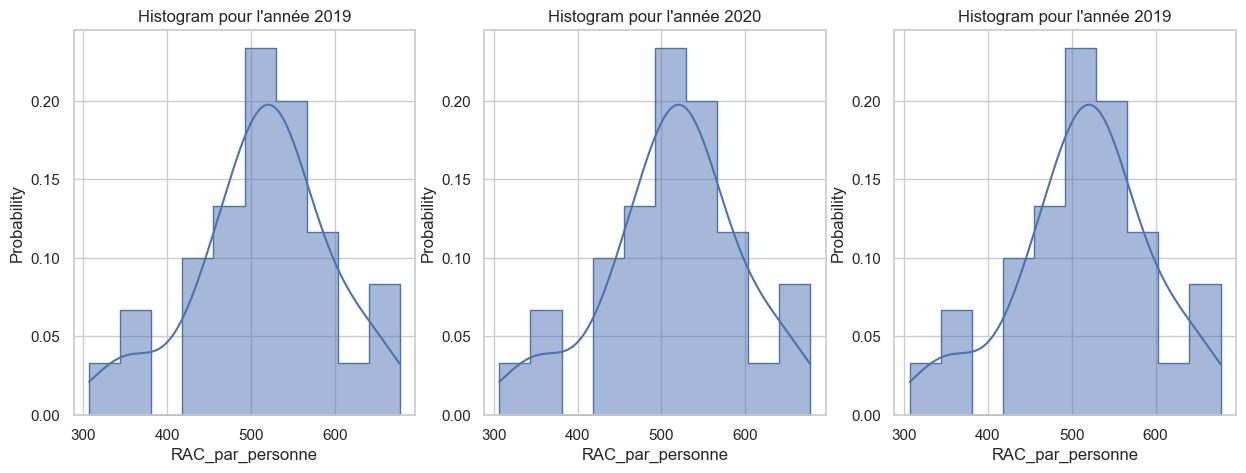

In [353]:
year = 2019
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].set_title(f"Histogram pour l'année {year}")
sns.histplot(data=get_all_data_beginning_from_year(year-2), x="RAC_par_personne", stat="probability", common_norm=False, bins=10, kde=True, palette="crest", alpha=.5, element="step", ax=axes[0])

axes[1].set_title(f"Histogram pour l'année {year+1}")
sns.histplot(data=get_all_data_beginning_from_year(year-1), x="RAC_par_personne", stat="probability", common_norm=False, bins=10, kde=True, palette="crest", alpha=.5, element="step", ax=axes[1])

axes[2].set_title(f"Histogram pour l'année {year}")
sns.histplot(data=get_all_data_beginning_from_year(year), x="RAC_par_personne", stat="probability", common_norm=False, bins=10, kde=True, palette="crest", alpha=.5, element="step", ax=axes[2])

plt.show()
glm_model, glm_results = GLM_model(year)

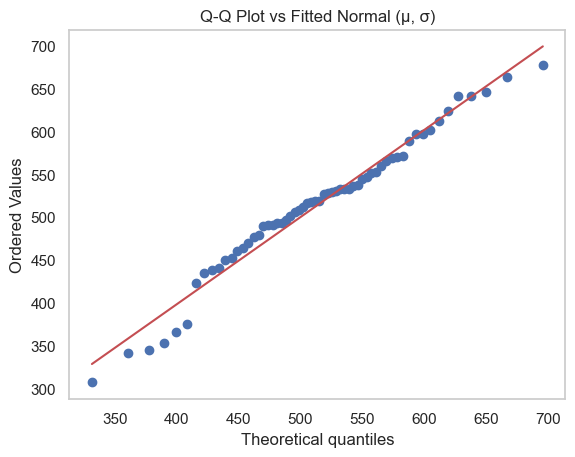

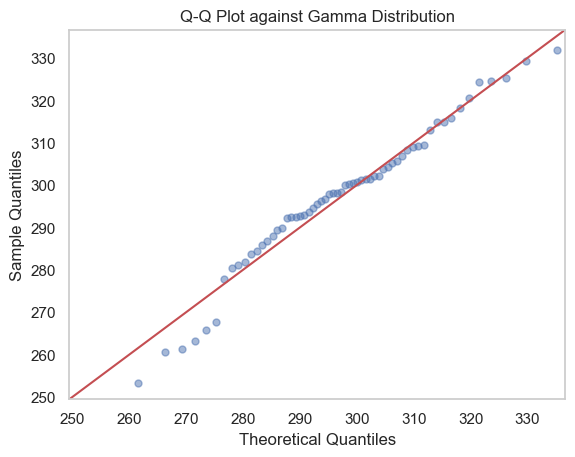

In [354]:
## q-q plots
get_q_q_plots(year)

In [355]:
# Résultats du model
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       RAC_par_personne   No. Observations:                   60
Model:                            GLM   Df Residuals:                       49
Model Family:                Gaussian   Df Model:                           10
Link Function:               Identity   Scale:                          446.60
Method:                          IRLS   Log-Likelihood:                -262.11
Date:                Sat, 10 May 2025   Deviance:                       21883.
Time:                        23:35:59   Pearson chi2:                 2.19e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Analyse de coefficients significatif

In [356]:
glm_results.pvalues
# Create a DataFrame for coefficients and their significance levels
coefficients_table = pd.DataFrame({
    'Coefficient': glm_results.params,
    'P-Value': glm_results.pvalues
})

# Add significance levels based on p-values
coefficients_table['Significance'] = coefficients_table['P-Value'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else '_'
)

# Reset index to include variable names
coefficients_table.reset_index(inplace=True)
coefficients_table.rename(columns={'index': 'Variable'}, inplace=True)

coefficients_table

,Variable,Coefficient,P-Value,Significance
0,const,-35689.721141,2.151858e-28,***
1,annee,17.931063,3.092301e-29,***
2,region_Bourgogne-Franche-Comté,-42.554105,4.871388e-04,***
3,region_Bretagne,-78.473652,1.261901e-10,***
4,region_Centre-Val-de-Loire,-58.579423,1.577459e-06,***
5,region_Grand Est et Hauts-de-France,-25.031313,4.021204e-02,**
6,region_Ile-de-France,38.985763,1.397003e-03,***
7,region_Normandie,-63.364512,2.065438e-07,***
8,region_Pays de la Loire,-67.109412,3.791859e-08,***
9,region_Provence-Alpes-Côte d'Azur et Corse,65.779436,6.995892e-08,***


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 40px"><b>Prédiction de la dérive de sinistralité en 2025</b></h2>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Test pour 2024</b></h2>

In [368]:
df_train = get_all_data_beginning_from_year(2019, 2023)
X_train = pd.get_dummies(df_train, columns = ['region'], drop_first = True,  dtype=int)
X_train = sm.add_constant(X_train)
y_train = X_train['RAC_par_personne']
X_train.drop(columns=['RAC_par_personne', 'RAC', 'population'], inplace=True)

glm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       RAC_par_personne   No. Observations:                   50
Model:                            GLM   Df Residuals:                       39
Model Family:                Gaussian   Df Model:                           10
Link Function:               Identity   Scale:                          509.16
Method:                          IRLS   Log-Likelihood:                -220.55
Date:                Sat, 10 May 2025   Deviance:                       19857.
Time:                        23:39:04   Pearson chi2:                 1.99e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [369]:
# Récupération des données pour l'année 2024, en excluant certaines colonnes inutiles pour la prédiction
X_test = get_all_data_beginning_from_year(2024).drop(columns=['RAC', 'population', 'RAC_par_personne'])

# Application de l'encodage one-hot sur la colonne 'region' pour transformer les catégories en variables binaires
X_test = pd.get_dummies(X_test, columns=['region'], drop_first=True, dtype=int)

# Alignement des colonnes de X_test avec celles de X_train pour garantir la cohérence des données
X_test = X_test.reindex(columns=X_train.columns, fill_value=1)

# Extraction des valeurs réelles de 'RAC_par_personne' pour l'année 2024
y_test = get_all_data_beginning_from_year(2024)['RAC_par_personne']

# Prédiction des valeurs de 'RAC_par_personne' à l'aide du modèle GLM entraîné
glm_model_predictions = glm_results.predict(X_test)

# Création d'un DataFrame pour comparer les valeurs réelles et prédites
Results_df = pd.concat(
    [
        X_test.reset_index(drop=True), 
        pd.DataFrame({'true_values': y_test.to_list(), 'predicted_values': glm_model_predictions.to_list()}).reset_index(drop=True)
    ], 
    axis=1
)

# Calcul et affichage de la MAPE (Mean Absolute Percentage Error) pour évaluer la précision du modèle
print("La MAPE pour le modèle GLM pour la prédiction du RAC est : {}%".format(round(mean_absolute_percentage_error(y_test, glm_model_predictions) * 100, 2)))

# Suppression des colonnes liées aux régions pour simplifier l'affichage des résultats
Results_df.drop(columns=[col for col in Results_df.columns if col.startswith('region')], inplace=True)


La MAPE pour le modèle GLM pour la prédiction du RAC est : 3.52%


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Prédiction du RAC 2025 - 2026
</b></h2>

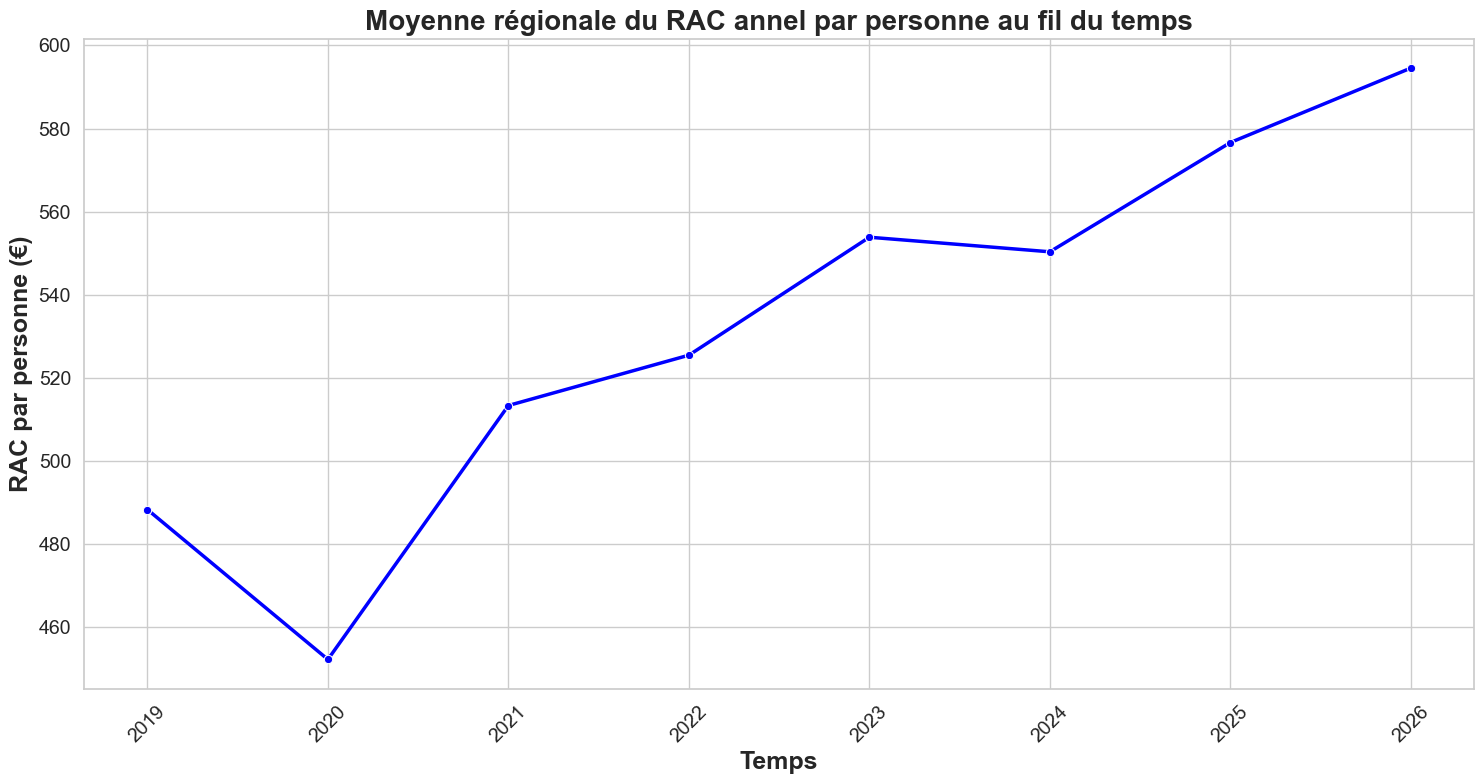

In [370]:
final_glm_model, final_glm_results = GLM_model(2019,2024)
data_prior_to_2024 = get_all_data_beginning_from_year(2019).drop(columns=['region', 'RAC', 'population']).groupby(['annee']).mean().reset_index()

# Préparer les données pour 2025
X_2025 = get_all_data_beginning_from_year(2024).drop(columns=['RAC', 'population', 'RAC_par_personne'])
X_2025 = pd.get_dummies(X_2025, columns=['region'], drop_first=True, dtype=int)
X_2025 = X_test.reindex(columns=X_train.columns, fill_value=1)
X_2025['annee'] = 2025

# Préparer les données pour 2026
X_2026 = get_all_data_beginning_from_year(2024).drop(columns=['RAC', 'population', 'RAC_par_personne'])
X_2026 = pd.get_dummies(X_2026, columns=['region'], drop_first=True, dtype=int)
X_2026 = X_test.reindex(columns=X_train.columns, fill_value=1)
X_2026['annee'] = 2026

# Générer les prédictions pour 2025 et 2026
predictions_2025 = final_glm_results.predict(X_2025)
predictions_2026 = final_glm_results.predict(X_2026)

# Créer des DataFrames pour les prédictions
Results_2025_df = pd.concat(
    [X_2025.reset_index(drop=True), 
     pd.DataFrame({'RAC_par_personne': predictions_2025.to_list()}).reset_index(drop=True)], 
    axis=1
).drop(columns=['const'])

Results_2026_df = pd.concat(
    [X_2026.reset_index(drop=True), 
     pd.DataFrame({'RAC_par_personne': predictions_2026.to_list()}).reset_index(drop=True)], 
    axis=1
).drop(columns=['const'])

# Agréger les résultats par année et mois
Results_2025_agregated_df = Results_2025_df[['annee', 'RAC_par_personne']].groupby(by=['annee',]).mean().reset_index()
Results_2026_agregated_df = Results_2026_df[['annee', 'RAC_par_personne']].groupby(by=['annee',]).mean().reset_index()

# Combiner toutes les données temporelles
all_temporal_data = pd.concat([data_prior_to_2024, Results_2025_agregated_df, Results_2026_agregated_df])

# Ajouter une colonne datetime pour la visualisation


# Tracer l'évolution de RAC_par_personne au fil du temps
plt.figure(figsize=(15, 8))
sns.lineplot(data=all_temporal_data, x='annee', y='RAC_par_personne', marker='o', linewidth=2.5, color='blue')

# Ajouter un titre et des étiquettes
plt.title("Moyenne régionale du RAC annel par personne au fil du temps", fontsize=20, fontweight='bold')
plt.xlabel("Temps", fontsize=18, fontweight='bold')
plt.ylabel("RAC par personne (€)", fontsize=18, fontweight='bold')

# Ajuster les ticks et la mise en page
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Afficher le graphique
plt.show()



**Remarque:** Cette visualisation pourrait suggérer que notre GLM n'est pas performant. Cependant, examinons les résultats obtenus : en dehors des données régionales que nous avons agrégées dans la visualisation ci-dessus, seules l'année et le mois sont utilisées comme variables explicatives. Cela produit un effet attendu : pour une année donnée, l'évolution du RAC est linéaire (car nous utilisons un GLM). Pour améliorer la performance du modèle, une option serait de créer des harmoniques à partir de la variable mois afin de capturer les variations mensuelles du RAC. Nous n'avons pas suivi cette approche dans ce Notebook, car nous avons privilégié une étude interprétable.